In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.tensorflow.org/tutorials/structured_data/time_series


# imports

In [ ]:
!pip install xgboost==1.0.1

     |████████████████████████████████| 109.8MB 94kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import glob as glob

import xgboost

from sklearn.preprocessing import StandardScaler
import sklearn

from os import sys

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
print(xgboost.__version__)

1.0.1


# Download data

## First Edition and process data (combine aicu columns)

In [ ]:
csv_ext = {'cropManage': 'CropManagement.csv',
                  'irr': 'Irrigation.csv',
                  'res' : 'ResourceCalculations.csv',
                  'climate' : 'Greenhouse_climate.csv',
                  'vip' : 'vip.csv',
                  'prod' : 'Production.csv'}

In [ ]:
# train
sonoma_path = '/content/drive/MyDrive/2021 Spring/datasets/autonomous_greenhouse/edition1/Sonoma_GH_Cucumber/AutonomousGreenhouseChallenge2018/Sonoma/'

# val
croperators_path = '/content/drive/MyDrive/2021 Spring/datasets/autonomous_greenhouse/edition1/croperators/AutonomousGreenhouseChallenge2018/Croperators/'

# test
# this one's vip is weird
aicu_path = '/content/drive/MyDrive/2021 Spring/datasets/autonomous_greenhouse/edition1/AiCU/AutonomousGreenhouseChallenge2018/AiCU/'


reference_path = '/content/drive/MyDrive/2021 Spring/datasets/autonomous_greenhouse/edition1/Reference_Growers_GH_Cucumber/AutonomousGreenhouseChallenge2018/Reference(Growers)/'


igrow_path = '/content/drive/MyDrive/2021 Spring/datasets/autonomous_greenhouse/edition1/igrow/AutonomousGreenhouseChallenge2018/iGrow/'

In [ ]:

sonoma_df_cropManage = pd.read_csv(sonoma_path + csv_ext['cropManage'])
sonoma_df_irr = pd.read_csv(sonoma_path + csv_ext['irr'])
sonoma_df_res = pd.read_csv(sonoma_path + csv_ext['res'])



# 5 min
sonoma_df_climate = pd.read_csv(sonoma_path + csv_ext['climate'])
# 5 min
sonoma_df_vip = pd.read_csv(sonoma_path + csv_ext['vip'])
# daily, probably only care about cumulative
sonoma_df_prod = pd.read_csv(sonoma_path + csv_ext['prod'])

# 5 min
croperator_df_climate = pd.read_csv(croperators_path + csv_ext['climate'])
# 5 min
croperator_df_vip = pd.read_csv(croperators_path + csv_ext['vip'])
# daily, probably only care about cumulative
croperator_df_prod = pd.read_csv(croperators_path + csv_ext['prod'])

# 5 min
aicu_df_climate = pd.read_csv(aicu_path + csv_ext['climate'])
# 5 min
aicu_df_vip = pd.read_csv(aicu_path + csv_ext['vip'])
# daily, probably only care about cumulative
aicu_df_prod = pd.read_csv(aicu_path + csv_ext['prod'])

# reference team
# reference_path
# 5 min
reference_df_climate = pd.read_csv(reference_path + csv_ext['climate'])
reference_df_vip = pd.read_csv(reference_path + csv_ext['vip'])
reference_df_prod = pd.read_csv(reference_path + csv_ext['prod'])

# 5 min
igrow_df_climate = pd.read_csv(igrow_path + csv_ext['climate'])
igrow_df_vip = pd.read_csv(igrow_path + csv_ext['vip'])
igrow_df_prod = pd.read_csv(igrow_path + csv_ext['prod'])



In [ ]:
reference_df_prod.columns

Index(['ProdA_cum', 'ProdA_num', 'ProdB_cum', 'ProdB_num', 'Prod_value_cum',
       'Total_Prod_cum', 'time'],
      dtype='object')

In [ ]:
print(len(sonoma_df_prod))
print(len(sonoma_df_climate))

116
33133


In [ ]:
sonoma_df_prod.iloc[1:3, 0:3]

,ProdA_cum,ProdA_num,ProdB_cum
1,0.0,0.0,0.0
2,0.0,0.0,0.0


## TODO: figure out waht is wrong with igrow

In [ ]:
climate_dfs = [sonoma_df_climate, croperator_df_climate, aicu_df_climate, reference_df_climate]
vip_dfs = [sonoma_df_vip, croperator_df_vip, aicu_df_vip, reference_df_vip]
prod_dfs = [sonoma_df_prod, croperator_df_prod, aicu_df_prod, reference_df_prod]


In [ ]:
def combine_aicu_vip_columns(aicu_df_vip):
  # take the column with the least amount of NaNs:
  column_names = ['HeatTemp_Vip', 'VentLeewMin_Vip', 'VentLeew_Vip', 'VentWind_Vip', 'WaterSupInt_Vip']

  # get the column with the least amount of NaN's.
  # if it has a NaN grab from others that maybe don't have NaN
  # iterate through rows

  # add a column for every column name here
  for c in column_names:
    aicu_df_vip[c] = np.nan

    # get all the columns that have c in the name
    column_arr = []
    for other_names in aicu_df_vip.columns:
      if c in other_names and c != other_names:
        column_arr.append(other_names)
    
    print(column_arr)

    # now only care about the ones with that column name in it
    df = aicu_df_vip[column_arr]

    # want the one with the minimnum amount of nans

    min_nans = sys.maxsize
    min_nan_col = c

    # for name in column_arr:
    #   if df[name].isnan().sum() < min_nans:
    #     min_nan_col = name

    aicu_df_vip[c].fillna(value=df.mean(axis=1), inplace=True)

    aicu_df_vip.drop(column_arr, 1, inplace=True)

    # for index, row in df.iterrows():
    #   # lets just get the average of all non_nan values
    #   mean = row.mean()
    #   print(mean)
    #   aicu_df_vip[c].loc[int(index)] = mean
    #   break



In [ ]:
combine_aicu_vip_columns(aicu_df_vip)

['HeatTemp_Vip_1', 'HeatTemp_Vip_2', 'HeatTemp_Vip_3', 'HeatTemp_Vip_4', 'HeatTemp_Vip_5', 'HeatTemp_Vip_6']
['VentLeewMin_Vip_1', 'VentLeewMin_Vip_2', 'VentLeewMin_Vip_3', 'VentLeewMin_Vip_4', 'VentLeewMin_Vip_5', 'VentLeewMin_Vip_6']
['VentLeew_Vip_1', 'VentLeew_Vip_2', 'VentLeew_Vip_3', 'VentLeew_Vip_4', 'VentLeew_Vip_5', 'VentLeew_Vip_6']
['VentWind_Vip_1', 'VentWind_Vip_2', 'VentWind_Vip_3', 'VentWind_Vip_4', 'VentWind_Vip_5', 'VentWind_Vip_6']
['WaterSupInt_Vip_1', 'WaterSupInt_Vip_2', 'WaterSupInt_Vip_3', 'WaterSupInt_Vip_4', 'WaterSupInt_Vip_5', 'WaterSupInt_Vip_6']


In [ ]:
aicu_df_vip.columns

Index(['CO2_Vip', 'HumDef_Vip', 'MinPipeGrow_Vip', 'MinPipeLow_Vip', 'time',
       'HeatTemp_Vip', 'VentLeewMin_Vip', 'VentLeew_Vip', 'VentWind_Vip',
       'WaterSupInt_Vip'],
      dtype='object')

In [ ]:
def check_samecolumns(df_arr):
  columns = df_arr[0].columns
  size = len(df_arr[0])

  for df in df_arr:
    try:
      assert(np.array_equal(df.columns, columns))
      assert(len(df) == size)
    except AssertionError:
      print(columns)
      print(df.columns)
  

In [ ]:
check_samecolumns(vip_dfs)

Index(['CO2_Vip', 'HeatTemp_Vip', 'HumDef_Vip', 'MinPipeGrow_Vip',
       'MinPipeLow_Vip', 'VentLeewMin_Vip', 'VentLeew_Vip', 'VentWind_Vip',
       'WaterSupInt_Vip', 'time'],
      dtype='object')
Index(['CO2_Vip', 'HumDef_Vip', 'MinPipeGrow_Vip', 'MinPipeLow_Vip', 'time',
       'HeatTemp_Vip', 'VentLeewMin_Vip', 'VentLeew_Vip', 'VentWind_Vip',
       'WaterSupInt_Vip'],
      dtype='object')


## Second Edition

In [ ]:
csv_ext_second = {'cropParams': 'CropManagement.csv',
                  'weather' : '',
                  'res' : '',
                  'irr': 'Irrigation.csv',
                  'res' : 'ResourceCalculations.csv',
                  'climate' : 'Greenhouse_climate.csv',
                  'vip' : 'vip.csv',
                  'prod' : 'Production.csv'}

## setup data for many to one label test setup

In [ ]:
sonoma_df_climate = sonoma_df_climate.rename(columns={'GHtime':'time'})

sonoma_df_climate

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,427.000000,0.0,43326.006944,3.34,0.0,0.0,80.4,19.9,52.900000,2.9
3,0.0,0.0,443.000000,0.0,43326.010417,3.36,0.0,0.0,80.4,19.9,52.900000,2.9
4,0.0,0.0,443.999999,0.0,43326.013889,3.29,0.0,0.0,80.9,19.9,51.099999,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...
33128,100.0,100.0,900.000004,0.0,43441.027778,3.41,28.4,28.2,84.9,24.5,0.000000,0.0
33129,100.0,100.0,965.000000,0.0,43441.031250,3.26,27.8,27.7,85.5,24.7,0.000000,0.0
33130,100.0,100.0,1169.999989,0.0,43441.034722,3.25,27.6,27.5,85.7,24.6,0.000000,0.0
33131,100.0,100.0,1001.000023,0.0,43441.038194,3.32,27.5,27.2,85.3,24.7,0.000000,0.0


In [ ]:
sonoma_df_vip

,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.003472
2,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN,43326.006944
3,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN,43326.010417
4,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN,43326.013889
...,...,...,...,...,...,...,...,...,...,...
33128,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.027778
33129,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.031250
33130,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.034722
33131,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.038194


In [ ]:
sonoma_X = sonoma_df_climate.merge(sonoma_df_vip, on="time")

In [ ]:
sonoma_X

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,427.000000,0.0,43326.006944,3.34,0.0,0.0,80.4,19.9,52.900000,2.9,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN
3,0.0,0.0,443.000000,0.0,43326.010417,3.36,0.0,0.0,80.4,19.9,52.900000,2.9,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN
4,0.0,0.0,443.999999,0.0,43326.013889,3.29,0.0,0.0,80.9,19.9,51.099999,2.9,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33128,100.0,100.0,900.000004,0.0,43441.027778,3.41,28.4,28.2,84.9,24.5,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0
33129,100.0,100.0,965.000000,0.0,43441.031250,3.26,27.8,27.7,85.5,24.7,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0
33130,100.0,100.0,1169.999989,0.0,43441.034722,3.25,27.6,27.5,85.7,24.6,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0
33131,100.0,100.0,1001.000023,0.0,43441.038194,3.32,27.5,27.2,85.3,24.7,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0


In [ ]:
sonoma_df_prod

,ProdA_cum,ProdA_num,ProdB_cum,ProdB_num,Prod_value_cum,Total_Prod_cum,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43326
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43327
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43328
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43329
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43330
...,...,...,...,...,...,...,...
111,48.098770,4.262295,0.126066,0.000000,45.346988,48.224836,43437
112,49.152910,2.786885,0.128852,0.081967,46.489611,49.281762,43438
113,49.306885,0.409836,0.129262,0.081967,46.681414,49.436148,43439
114,50.372787,2.827869,0.132090,0.081967,47.840430,50.504877,43440


In [ ]:
arr = []

prev_row = 0
for rows in sonoma_df_prod.iterrows():
  # print(rows[1][5])
  arr.append(rows[1][5] - prev_row)
  prev_row = rows[1][5]

print(arr)

sonoma_df_prod['Prod_Cum_Diff'] = pd.Series(arr)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15790983606557402, 0.820942622950819, 0.9448770491803269, 0.0, 1.2039344262295104, 0.4294262295081994, 0.3975000000000004, 0.4986475409836002, 0.70176229508197, 0.5426639344262298, 0.0, 0.7459426229508201, 0.7329098360655699, 0.6571721311475391, 0.9272131147541005, 0.9535655737705007, 0.3494262295082393, 0.0, 1.4478278688524018, 1.1077459016393991, 0.4998770491803004, 0.4647131147540975, 0.38483606557380234, 0.18536885245899803, 0.0, 0.7761065573770001, 0.0, 1.9695901639344005, 0.5679918032787015, 0.6240573770492013, 0.7630327868852973, 0.0, 0.9741393442622979, 0.4175819672131027, 0.1282377049179999, 0.3094262295082011, 0.22426229508199924, 0.4021721311474984, 0.0, 0.6966803278689007, 0.6332786885245021, 1.5199999999999996, 0.14434426229509612, 0.36885245901640573, 0.7002049180327923, 0.0, 0.47192622950820606, 0.4108196721312005, 0.2963114754098015, 0.7086065573769993, 

In [ ]:
sonoma_df_prod

,ProdA_cum,ProdA_num,ProdB_cum,ProdB_num,Prod_value_cum,Total_Prod_cum,time,Prod_Cum_Diff
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43326,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43327,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43328,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43329,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43330,0.000000
...,...,...,...,...,...,...,...,...
111,48.098770,4.262295,0.126066,0.000000,45.346988,48.224836,43437,1.641025
112,49.152910,2.786885,0.128852,0.081967,46.489611,49.281762,43438,1.056926
113,49.306885,0.409836,0.129262,0.081967,46.681414,49.436148,43439,0.154385
114,50.372787,2.827869,0.132090,0.081967,47.840430,50.504877,43440,1.068730


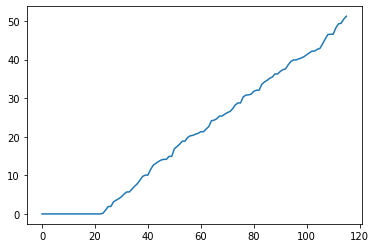

In [ ]:
# upsample data from daily measurmeents to 5 minute measurements
# sonoma_df_prod['Total_Prod_cum'].plot()

sonoma_df_prod['Total_Prod_cum'].plot()

In [ ]:
sonoma_df_prod['time'] = sonoma_df_prod['time'] - sonoma_df_prod['time'].min() + 1

In [ ]:
sonoma_df_prod

,ProdA_cum,ProdA_num,ProdB_cum,ProdB_num,Prod_value_cum,Total_Prod_cum,time,Prod_Cum_Diff
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0.000000
...,...,...,...,...,...,...,...,...
111,48.098770,4.262295,0.126066,0.000000,45.346988,48.224836,112,1.641025
112,49.152910,2.786885,0.128852,0.081967,46.489611,49.281762,113,1.056926
113,49.306885,0.409836,0.129262,0.081967,46.681414,49.436148,114,0.154385
114,50.372787,2.827869,0.132090,0.081967,47.840430,50.504877,115,1.068730


In [ ]:
s = pd.to_timedelta(sonoma_df_prod['time'], unit='D')

In [ ]:
s

0       1 days
1       2 days
2       3 days
3       4 days
4       5 days
        ...   
111   112 days
112   113 days
113   114 days
114   115 days
115   116 days
Name: time, Length: 116, dtype: timedelta64[ns]

In [ ]:
sonoma_df_prod['date'] = pd.Timestamp('2021-04-12')

In [ ]:
sonoma_df_prod['date'] = sonoma_df_prod['date'] +  s

In [ ]:
sonoma_df_prod

,ProdA_cum,ProdA_num,ProdB_cum,ProdB_num,Prod_value_cum,Total_Prod_cum,time,Prod_Cum_Diff,date
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,2021-04-13
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,2021-04-14
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,2021-04-15
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.000000,2021-04-16
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0.000000,2021-04-17
...,...,...,...,...,...,...,...,...,...
111,48.098770,4.262295,0.126066,0.000000,45.346988,48.224836,112,1.641025,2021-08-02
112,49.152910,2.786885,0.128852,0.081967,46.489611,49.281762,113,1.056926,2021-08-03
113,49.306885,0.409836,0.129262,0.081967,46.681414,49.436148,114,0.154385,2021-08-04
114,50.372787,2.827869,0.132090,0.081967,47.840430,50.504877,115,1.068730,2021-08-05


In [ ]:
sonoma_df_prod.dtypes

ProdA_cum                float64
ProdA_num                float64
ProdB_cum                float64
ProdB_num                float64
Prod_value_cum           float64
Total_Prod_cum           float64
time                       int64
Prod_Cum_Diff            float64
date              datetime64[ns]
dtype: object

In [ ]:
sDateTime = sonoma_df_prod.set_index('date')

In [ ]:
sUpsampled = sDateTime['Prod_Cum_Diff'].resample('5T').interpolate(method='linear')

In [ ]:
sonoma_Y = sUpsampled


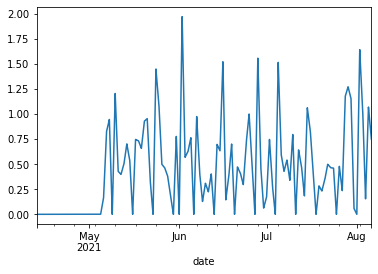

In [ ]:
sonoma_Y.plot()

In [ ]:
X = sonoma_X[sonoma_X['time'] <= 43441]

# XG Boost model

n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth: The maximum depth of each tree, often values are between 1 and 10.
eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.


In [ ]:
def get_null_column_count(df):
  print(df.isnull().sum(axis = 0))
  print(df.isnull().sum(axis = 0) / len(df))

def preprocess_vip(df_vip):
  # i think i want to preprocess to deal with NaN values, make 0

  # .loc is preferred method of modifying entries in place

  print(df_vip.head())
  print(f'Length of dataframe: {len(df_vip)}')
  print(f'CO2 vip is null: {df_vip["CO2_Vip"].isnull().sum()}')
  print(f'HeatTemp_Vip_1 is null: {df_vip["HeatTemp_Vip"].isnull().sum()}')

def get_X_Y_firstEdition(df_climate, df_vip, df_prod, date='2018-08-20', resampling_method = '5T', y_column='Prod_Cum_Diff'):
  """
  date : (optional) this is the date the experiment started for Edition 1
  resampling_method: (optional) the pandas resampling string represntation. Default is 5 minute intervals
  y_column: (optional) defaults to the produciton at that 
  """
  # merge on vip and prod
  
  df_prod = df_prod.copy()
  arr = []

  prev_row = 0
  for rows in df_prod.iterrows():
    # print(rows[1][5])
    arr.append(rows[1][5] - prev_row)
    prev_row = rows[1][5]
    
  df_prod['Prod_Cum_Diff'] = pd.Series(arr)


  df_climate = df_climate.copy()
  df_vip = df_vip.copy()

  df_climate = df_climate.rename(columns={'GHtime':'time'}) 

  X = df_climate.merge(df_vip, on="time")

  df_prod['time'] = df_prod['time'] - df_prod['time'].min() + 1

  s = pd.to_timedelta(df_prod['time'], unit='D')
  # print(s)

  df_prod['date'] = pd.Timestamp(date)

  df_prod['date'] = df_prod['date'] +  s

  sDateTime = df_prod.set_index('date')

  sUpsampled = sDateTime[y_column].resample(resampling_method).interpolate(method='linear')

  # since the prod only goes up to a certain date, the environment data trickles
  # longer
  # print(X)
  X = X[X['time'] <= 43441]
  

  X['date'] = sUpsampled.values

  X.dropna(0,'any',inplace=True)

  Y = X['date']

  X = X.drop('date', axis=1)

  # normalize the time
  X['time'] = X['time'] - X['time'].min() + 1

  # Don't normalize yield
  y_scaled = Y


  return X, y_scaled

Arrays of the dataframes

- climate_dfs
- vip_dfs
- prod_dfs


In [ ]:
for d in vip_dfs:
  print("Null Counts")
  get_null_column_count(d)
  break

Null Counts
CO2_Vip            580
HeatTemp_Vip       141
HumDef_Vip         141
MinPipeGrow_Vip    141
MinPipeLow_Vip     141
VentLeewMin_Vip    142
VentLeew_Vip       141
VentWind_Vip       141
WaterSupInt_Vip    580
time                 0
dtype: int64
CO2_Vip            0.017505
HeatTemp_Vip       0.004256
HumDef_Vip         0.004256
MinPipeGrow_Vip    0.004256
MinPipeLow_Vip     0.004256
VentLeewMin_Vip    0.004286
VentLeew_Vip       0.004256
VentWind_Vip       0.004256
WaterSupInt_Vip    0.017505
time               0.000000
dtype: float64


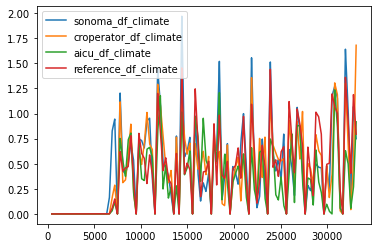

In [ ]:
# concatenate all of the data here

X_arr = []
Y_arr = []

labels = ['sonoma_df_climate', 'croperator_df_climate', 'aicu_df_climate', 'reference_df_climate']
fig, ax = plt.subplots()

# times to skip



for index, (climate_df, vip_df, prod_df) in enumerate(zip(climate_dfs, vip_dfs, prod_dfs)):
  X, Y = get_X_Y_firstEdition(climate_df, vip_df, prod_df)
  X_arr.append(X)
  Y_arr.append(Y)
  Y.plot(legend=True, ax=ax)

ax.legend(labels)

vertical_stack_X = pd.concat(X_arr, axis=0)
vertical_stack_Y = pd.concat(Y_arr, axis=0)



In [ ]:
vertical_stack_X

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip
440,0.0,0.0,425.000000,0.0,1.000000,8.60,0.0,0.0,61.1,24.2,99.4,4.2,600.0,20.0,0.0,0.0,0.0,0.0,21.0,24.0,240.0
441,0.0,0.0,413.000002,0.0,1.003472,8.85,0.0,0.0,60.2,24.5,99.4,5.5,600.0,20.0,0.0,0.0,0.0,0.0,21.0,24.0,240.0
442,0.0,0.0,434.999998,0.0,1.006944,9.49,0.0,0.0,58.5,24.9,99.4,10.2,600.0,20.0,0.0,0.0,0.0,0.0,21.0,24.0,240.0
443,0.0,0.0,401.000001,0.0,1.010417,9.94,0.0,0.0,57.5,25.3,99.4,15.0,600.0,20.0,0.0,0.0,0.0,0.0,21.0,24.0,240.0
444,0.0,0.0,398.000000,0.0,1.013889,10.31,0.0,0.0,56.4,25.5,99.4,15.0,600.0,20.0,0.0,0.0,0.0,0.0,21.0,24.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33116,0.0,85.3,644.999999,96.7,114.458333,1.97,0.0,29.5,88.1,19.3,0.7,0.0,400.0,19.0,2.2,0.0,0.0,0.0,20.0,28.0,15.0
33117,0.0,85.3,619.000004,96.7,114.461806,1.89,0.0,28.9,88.5,19.2,0.7,0.0,400.0,19.0,2.2,0.0,0.0,0.0,20.0,28.0,15.0
33118,0.0,85.3,654.999995,96.7,114.465278,1.87,0.0,29.7,88.4,18.9,0.7,0.0,400.0,19.0,2.2,0.0,0.0,0.0,20.0,28.0,15.0
33119,0.0,85.3,655.000000,96.2,114.468750,1.77,0.0,31.1,89.1,19.0,0.7,0.0,400.0,19.0,2.2,0.0,0.0,0.0,20.0,28.0,15.0


In [ ]:
vertical_stack_Y.mean()

0.4065642711914089

In [ ]:
def split_sequences(x_seq, y_seq, n_steps):
  X, y = list(), list()

  for i in range(0, len(x_seq)):
    end_ix = int(i + n_steps)
    # print(i)
    # print(end_ix)

    if end_ix > len(y_seq) - 1:
      break
    
    seq_x, seq_y = x_seq.iloc[i:end_ix, :].to_numpy(), y_seq.iloc[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
data_steps = int(60 / 5)
features = len(vertical_stack_X.columns)

In [ ]:
# # data_steps for how many x points per y point, in 5-minute intervals

# # hours for a y_step
# y_steps = 1
# X = []
# Y = []

# for x_series, y_series in zip(X_arr, Y_arr):
#   x_seq, y_seq = split_sequences(x_series, y_series, data_steps)
#   X.append(x_seq)
#   Y.append(y_seq)
  
#   print(np.array(x_seq).shape)
#   print(np.array(y_seq).shape)

# X = np.array(X)
# Y = np.array(Y)

# X = np.reshape(X, (-1, X.shape[2], X.shape[3]))
# Y = Y.flatten()
# print(X.shape)
# print(Y.shape)

(32528, 12, 21)
(32528,)
(32529, 12, 21)
(32529,)
(32528, 12, 21)
(32528,)
(32528, 12, 21)
(32528,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


IndexError: ignored

In [ ]:
X, Y = split_sequences(vertical_stack_X, vertical_stack_Y, data_steps)

In [ ]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=X,
      targets=Y,
      sequence_length=data_steps,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)


In [ ]:
ds = tf.data.Dataset.from_tensor_slices((X, Y))
ds

<TensorSliceDataset shapes: ((12, 21), ()), types: (tf.float64, tf.float64)>

In [ ]:
tf.data

<module 'tensorflow._api.v2.data' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/data/__init__.py'>

In [ ]:
batched_ds = ds.shuffle(1000).batch(32)

In [ ]:
batched_ds

<BatchDataset shapes: ((None, 12, 21), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
def get_vanilla_LSTM():
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(data_steps, features)))
  model.add(Dense(1))
  rme = tf.keras.metrics.RootMeanSquaredError(name='rme')
  model.compile(optimizer='adam', loss='mse', metrics=['mse', rme])
  return model

In [ ]:
model = get_vanilla_LSTM()

In [ ]:
train = batched_ds.take(int(X.shape[0]*.8))
test = batched_ds.skip(int(X.shape[0]*.8)).take(int(X.shape[0]*.2))

In [ ]:
train

<TakeDataset shapes: ((None, 12, 21), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
test

<TakeDataset shapes: ((None, 12, 21), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
for i in train.take(100):
  print("here")

In [ ]:
# test_X = X[int(-X.shape[0]*.2):]
# train_X = X[:int(X.shape[0]*.8)]

# test_Y = Y[int(-Y.shape[0]*.2):]
# train_Y = Y[:int(Y.shape[0]*.8)]

In [ ]:
history = model.fit(train, epochs=20, verbose=2)

Epoch 1/20
4068/4068 - 108s - loss: 674.5546 - mse: 674.5546 - rme: 25.9722
Epoch 2/20
4068/4068 - 106s - loss: 2.5310 - mse: 2.5310 - rme: 1.5909
Epoch 3/20
4068/4068 - 106s - loss: 0.3281 - mse: 0.3281 - rme: 0.5728
Epoch 4/20
4068/4068 - 106s - loss: 0.2663 - mse: 0.2663 - rme: 0.5160
Epoch 5/20
4068/4068 - 106s - loss: 0.2949 - mse: 0.2949 - rme: 0.5431
Epoch 6/20
4068/4068 - 106s - loss: 0.1951 - mse: 0.1951 - rme: 0.4417
Epoch 7/20
4068/4068 - 106s - loss: 0.1386 - mse: 0.1386 - rme: 0.3722
Epoch 8/20
4068/4068 - 105s - loss: 0.0775 - mse: 0.0775 - rme: 0.2784
Epoch 9/20
4068/4068 - 105s - loss: 0.0774 - mse: 0.0774 - rme: 0.2782
Epoch 10/20
4068/4068 - 106s - loss: 0.0737 - mse: 0.0737 - rme: 0.2715
Epoch 11/20
4068/4068 - 105s - loss: 0.0729 - mse: 0.0729 - rme: 0.2700
Epoch 12/20
4068/4068 - 105s - loss: 0.0726 - mse: 0.0726 - rme: 0.2694
Epoch 13/20
4068/4068 - 104s - loss: 0.0775 - mse: 0.0775 - rme: 0.2784
Epoch 14/20
4068/4068 - 106s - loss: 0.0727 - mse: 0.0727 - rme: 0.2

In [ ]:
model.save('/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/models/LSTM_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/models/LSTM_model/assets


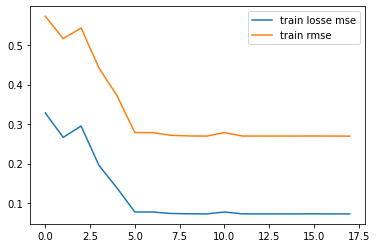

In [ ]:
plt.plot(history.history['loss'][2:], label='train losse mse')
plt.plot(history.history['rme'][2:], label='train rmse')
plt.legend()
plt.show()

In [ ]:
print(history.history['loss'])

[674.5546264648438, 2.530961751937866, 0.32806622982025146, 0.2663007378578186, 0.2949412763118744, 0.19513793289661407, 0.13856029510498047, 0.07750922441482544, 0.07741931080818176, 0.07372666895389557, 0.07287615537643433, 0.07258524000644684, 0.07747912406921387, 0.07272491604089737, 0.07268717885017395, 0.07267177850008011, 0.07272383570671082, 0.07278495281934738, 0.07268586754798889, 0.07260330766439438]


In [ ]:
model_metrics = model.evaluate(test_X, test_Y)
for name, score in zip(model.metrics_names,model_metrics):
  print(f'{name} : {score} \n')

814/814 [==============================] - 4s 5ms/step - loss: 0.2305 - mse: 0.2305 - rme: 0.4801
loss : 0.23049511015415192 

mse : 0.23049511015415192 

rme : 0.48009905219078064 



In [ ]:
import tensorflow

In [ ]:
model.metrics_names

['loss', 'mse', 'rme']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

In [ ]:
xg_model = xgboost.XGBRegressor()


cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# runs all of these repeated k folds, and then computes teh r2 scores for the various 
# cuts of the datasets
scores = cross_val_score(xg_model, vertical_stack_X, vertical_stack_Y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)




In [ ]:
scores

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [ ]:
r2_scores = cross_val_score(model, vertical_stack_X, vertical_stack_Y, scoring='r2', cv=cv, n_jobs=-1)

In [ ]:
print(r2_scores)
print(r2_scores.mean())

[0.65450867 0.65415183 0.65301949 0.65441814 0.654197   0.65622974
 0.65302418 0.64665554 0.66072719 0.64942985 0.6589842  0.65251934
 0.65811959 0.65482799 0.65599183]
0.6544536388446768


In [ ]:
scores = np.absolute(scores)
print(scores)

[0.20113359 0.20113585 0.19897999 0.19972813 0.19979829 0.20125581
 0.19930105 0.20201334 0.19698638 0.20241741 0.19887587 0.20009318
 0.19852941 0.199789   0.20055623]


In [ ]:
print(scores.mean())

0.2000395676583121


In [ ]:
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor


# prepare a list of ml models
def get_models(models=dict()):
	# non-linear models
  n_trees = 10
  # TINY
  models['knn'] = KNeighborsRegressor(n_neighbors=7)
  models['cart'] = DecisionTreeRegressor()
  models['extra'] = ExtraTreeRegressor()
  # models['svmr'] = SVR()
  # # ensemble models
  # n_trees = 100
  models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
  models['bag'] = BaggingRegressor(n_estimators=n_trees)
  models['rf'] = RandomForestRegressor(n_estimators=n_trees)
  models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
  models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
  print('Defined %d models' % len(models))
  return models

# evaluate a suite of models
def evaluate_models(models):
  dropped_time = vertical_stack_X.drop('time', axis=1)
  for name, model in models.items():
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, dropped_time, vertical_stack_Y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    print(f'Model: {name} MSE: {scores.mean()}')


In [ ]:
models = get_models()
# evaluate models
evaluate_models(models)

Defined 8 models
Model: knn MSE: -0.24257132063095363
Model: cart MSE: -0.19180486594900836
Model: extra MSE: -0.19780436478261665
Model: ada MSE: -0.30912130770279733
Model: bag MSE: -0.1405547925830781
Model: rf MSE: -0.14014356576879852
Model: et MSE: -0.12580409363646916
Model: gbm MSE: -0.3042995010855038


In [ ]:
# split each chunk into train/test sets
# split the dataset by 'chunkID', return a dict of id to rows
def to_chunks(values, chunk_ix=1):
	chunks = dict()
	# get the unique chunk ids
	chunk_ids = np.unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks[chunk_id] = values[selection, :]
	return chunks

def split_train_test(chunks, row_in_chunk_ix=2):
	train, test = list(), list()
	# first 5 days of hourly observations for train
	cut_point = 5 * 24
	# enumerate chunks
	for k,rows in chunks.items():
		# split chunk rows by 'position_within_chunk'
		train_rows = rows[rows[:,row_in_chunk_ix] <= cut_point, :]
		test_rows = rows[rows[:,row_in_chunk_ix] > cut_point, :]
		if len(train_rows) == 0 or len(test_rows) == 0:
			print('>dropping chunk=%d: train=%s, test=%s' % (k, train_rows.shape, test_rows.shape))
			continue
		# store with chunk id, position in chunk, hour and all targets
		indices = [1,2,5] + [x for x in range(56,train_rows.shape[1])]
		train.append(train_rows[:, indices])
		test.append(test_rows[:, indices])
	return train, test
# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]
 
# convert the rows in a test chunk to forecasts
def to_forecasts(test_chunks, row_in_chunk_ix=1):
	# get lead times
	lead_times = get_lead_times()
	# first 5 days of hourly observations for train
	cut_point = 5 * 24
	forecasts = list()
	# enumerate each chunk
	for rows in test_chunks:
		chunk_id = rows[0, 0]
		# enumerate each lead time
		for tau in lead_times:
			# determine the row in chunk we want for the lead time
			offset = cut_point + tau
			# retrieve data for the lead time using row number in chunk
			row_for_tau = rows[rows[:,row_in_chunk_ix]==offset, :]
			# check if we have data
			if len(row_for_tau) == 0:
				# create a mock row [chunk, position, hour] + [nan...]
				row = [chunk_id, offset, nan] + [nan for _ in range(39)]
				forecasts.append(row)
			else:
				# store the forecast row
				forecasts.append(row_for_tau[0])
	return array(forecasts)
 

chunks = to_chunks(total.values)
train, test = split_train_test(chunks)

>dropping chunk=0: train=(0, 22), test=(79312, 22)
>dropping chunk=0: train=(0, 22), test=(4, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(3, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(3, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(3, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(2, 22)
>dropping chunk=0: train=(0, 22), test=(4, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(6, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping chunk=0: train=(0, 22), test=(5, 22)
>dropping chunk=0: train=(0, 22), test=(3, 22)
>dropping chunk=0: train=(0, 22), test=(5, 22)
>dropping chunk=0: train=(0, 22), test=(1, 22)
>dropping

# Prophet

In [ ]:
import fbprophet


TODO: test this model on other 

In [ ]:
vertical_stack_X.columns


Index(['AssimLight', 'BlackScr', 'CO2air', 'EnScr', 'HumDef', 'PipeGrow',
       'PipeLow', 'RHair', 'Tair', 'VentLee', 'Ventwind', 'CO2_Vip',
       'HeatTemp_Vip', 'HumDef_Vip', 'MinPipeGrow_Vip', 'MinPipeLow_Vip',
       'VentLeewMin_Vip', 'VentLeew_Vip', 'VentWind_Vip', 'WaterSupInt_Vip'],
      dtype='object')

ValueError: ignored

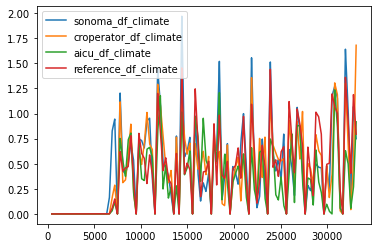

In [ ]:

X_arr = []
Y_arr = []

labels = ['sonoma_df_climate', 'croperator_df_climate', 'aicu_df_climate', 'reference_df_climate']
fig, ax = plt.subplots()
for index, (climate_df, vip_df, prod_df) in enumerate(zip(climate_dfs, vip_dfs, prod_dfs)):
  X, Y = get_X_Y_firstEdition(climate_df, vip_df, prod_df)
  X_arr.append(X)
  Y_arr.append(Y)
  Y.plot(legend=True, ax=ax)

ax.legend(labels)

vertical_stack_X = pd.concat(X_arr, axis=0)
vertical_stack_Y = pd.concat(Y_arr, axis=0)



In [ ]:
vertical_stack_X['y'] = vertical_stack_Y

In [ ]:
# Prophet requires columns ds (Date) and y (value)
vertical_stack_X = vertical_stack_X.rename(columns={'time': 'ds'})

# Make the prophet model and fit on the data
grow_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
grow_prophet.fit(vertical_stack_X)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


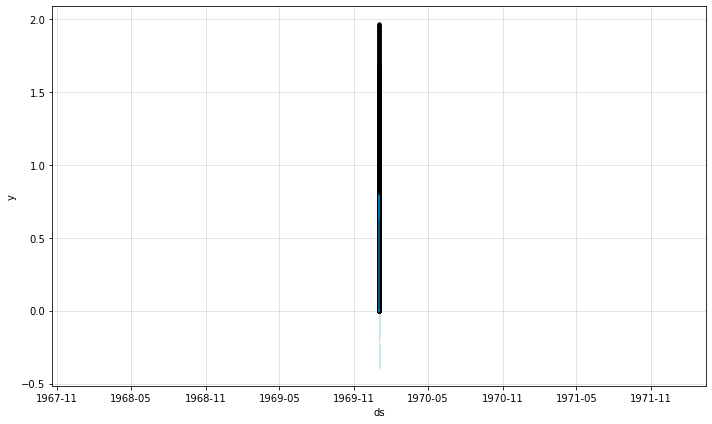

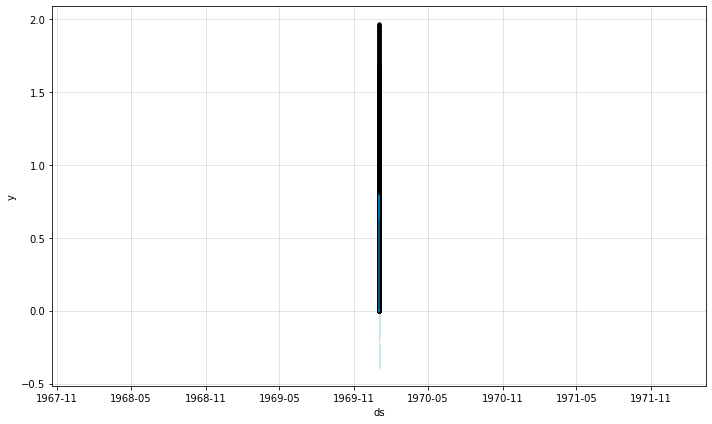

In [ ]:
grow_prophet.plot(grow_prophet.predict())

In [ ]:
# Make a future dataframe for 2 years
grow_forecast = grow_prophet.make_future_dataframe(periods=2, freq='M')
# Make predictions
grow_forecast = grow_prophet.predict(grow_forecast)

MemoryError: ignored

In [ ]:
grow_prophet.plot(grow_forecast, xlabel = 'time', ylabel = 'Crop production')
plt.title('Estimated Crop Produciton given these things');

where i need to go: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/


for LSTM now that we know how to extend data
https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/#:~:text=A%20many%2Dto%2Done%20model%20produces%20one%20output%20value,after%20receiving%20multiple%20input%20values.&text=The%20internal%20state%20is%20accumulated%20with%20each%20input%20value%20before,forecast%20the%20next%20time%20step.



# Preprocess data


In [ ]:
def remove_nonhours_climate(df):
  df  = df[df['GHtime'].astype('int32') >= df['GHtime']]
  df = df.rename(columns={'GHtime':'time'})
  return df

def remove_nonhours_vip(df):
  df  = df[df['time'].astype('int32') >= df['time']]
  return df

In [ ]:
def preprocess_data(path):
  df_cropManage = pd.read_csv(path + csv_ext['cropManage'])
  df_irr = pd.read_csv(path + csv_ext['irr'])
  df_res = pd.read_csv(path + csv_ext['res'])
  df_climate = pd.read_csv(path + csv_ext['climate'])
  df_vip = pd.read_csv(path + csv_ext['vip'])
  df_prod = pd.read_csv(path + csv_ext['prod'])

  df_climate  = remove_nonhours_climate(df_climate)
  df_vip = remove_nonhours_vip(df_vip)

  df = df_climate.merge(df_vip, on="time").merge(df_irr, on="time")

  Y = df_prod

  
  df['time'] = df['time'] - df['time'].min()

  Y['time'] = Y['time'] - Y['time'].min()

  return df, Y


In [ ]:
# sonoma_df_climate  = remove_nonhours_climate(sonoma_df_climate)


In [ ]:
sonoma_df_climate.head()

,AssimLight,BlackScr,CO2air,EnScr,GHtime,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,427.000000,0.0,43326.006944,3.34,0.0,0.0,80.4,19.9,52.900000,2.9
3,0.0,0.0,443.000000,0.0,43326.010417,3.36,0.0,0.0,80.4,19.9,52.900000,2.9
4,0.0,0.0,443.999999,0.0,43326.013889,3.29,0.0,0.0,80.9,19.9,51.099999,2.9


In [ ]:
sonoma_df_climate

,AssimLight,BlackScr,CO2air,EnScr,GHtime,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,427.000000,0.0,43326.006944,3.34,0.0,0.0,80.4,19.9,52.900000,2.9
3,0.0,0.0,443.000000,0.0,43326.010417,3.36,0.0,0.0,80.4,19.9,52.900000,2.9
4,0.0,0.0,443.999999,0.0,43326.013889,3.29,0.0,0.0,80.9,19.9,51.099999,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...
33128,100.0,100.0,900.000004,0.0,43441.027778,3.41,28.4,28.2,84.9,24.5,0.000000,0.0
33129,100.0,100.0,965.000000,0.0,43441.031250,3.26,27.8,27.7,85.5,24.7,0.000000,0.0
33130,100.0,100.0,1169.999989,0.0,43441.034722,3.25,27.6,27.5,85.7,24.6,0.000000,0.0
33131,100.0,100.0,1001.000023,0.0,43441.038194,3.32,27.5,27.2,85.3,24.7,0.000000,0.0


In [ ]:
# sonoma_df_vip = remove_nonhours_vip(sonoma_df_vip)

In [ ]:
sonoma_df_vip.head()

,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.003472
2,NaN,12.0,0.0,0.0,0.0,0.0,20.0,20.0,NaN,43326.006944
3,NaN,12.0,0.0,0.0,0.0,0.0,20.0,20.0,NaN,43326.010417
4,NaN,12.0,0.0,0.0,0.0,0.0,20.0,20.0,NaN,43326.013889


In [ ]:
sonoma_df_vip.dtypes

CO2_Vip            float64
HeatTemp_Vip       float64
HumDef_Vip         float64
MinPipeGrow_Vip    float64
MinPipeLow_Vip     float64
VentLeewMin_Vip    float64
VentLeew_Vip       float64
VentWind_Vip       float64
WaterSupInt_Vip    float64
time               float64
dtype: object

In [ ]:
# join them all on time
# sonoma_df = sonoma_df_climate.merge(sonoma_df_vip, on="time").merge(sonoma_df_irr, on="time")
sonoma_df = sonoma_df_climate.merge(sonoma_df_vip, left_on="GHtime", right_on="time" )

In [ ]:
sonoma_df_irr.dtypes
# need to incorpoate the dtype int from sonoma_df_irr

EC_Drain    float64
drain       float64
pH_Drain    float64
time          int64
water       float64
dtype: object

In [ ]:
Y = sonoma_df_prod

In [ ]:
Y.head()

,ProdA_cum,ProdA_num,ProdB_cum,ProdB_num,Prod_value_cum,Total_Prod_cum,time
0,0.0,0.0,0.0,0.0,0.0,0.0,43326
1,0.0,0.0,0.0,0.0,0.0,0.0,43327
2,0.0,0.0,0.0,0.0,0.0,0.0,43328
3,0.0,0.0,0.0,0.0,0.0,0.0,43329
4,0.0,0.0,0.0,0.0,0.0,0.0,43330


In [ ]:
sonoma_df

,AssimLight,BlackScr,CO2air,EnScr,GHtime,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,time
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.000000
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.003472
2,0.0,0.0,427.000000,0.0,43326.006944,3.34,0.0,0.0,80.4,19.9,52.900000,2.9,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN,43326.006944
3,0.0,0.0,443.000000,0.0,43326.010417,3.36,0.0,0.0,80.4,19.9,52.900000,2.9,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN,43326.010417
4,0.0,0.0,443.999999,0.0,43326.013889,3.29,0.0,0.0,80.9,19.9,51.099999,2.9,NaN,12.0,0.00,0.0,0.0,0.0,20.0,20.0,NaN,43326.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33128,100.0,100.0,900.000004,0.0,43441.027778,3.41,28.4,28.2,84.9,24.5,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.027778
33129,100.0,100.0,965.000000,0.0,43441.031250,3.26,27.8,27.7,85.5,24.7,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.031250
33130,100.0,100.0,1169.999989,0.0,43441.034722,3.25,27.6,27.5,85.7,24.6,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.034722
33131,100.0,100.0,1001.000023,0.0,43441.038194,3.32,27.5,27.2,85.3,24.7,0.000000,0.0,969.0,22.4,1.82,27.5,27.5,0.0,32.0,32.0,70.0,43441.038194


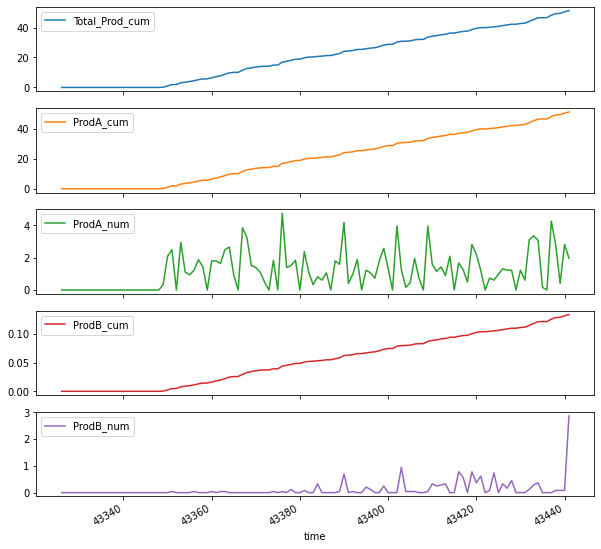

In [ ]:
plot_cols = ['Total_Prod_cum', 'ProdA_cum', 'ProdA_num', 'ProdB_cum', 'ProdB_num' ]
plot_features = Y[plot_cols]
plot_features.index = Y['time']
_ = plot_features.plot(subplots=True, figsize=(10,10))

# plot_features = Y[plot_cols]
# plot_features.index = Y['time']
# _ = plot_features.plot(subplots=True)

In [ ]:
sonoma_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AssimLight,113.0,53.097345,50.126263,0.000000,0.000000,100.000000,100.000000,100.000000
BlackScr,113.0,50.493805,48.277128,0.000000,0.000000,62.800000,100.000000,100.000000
CO2air,113.0,757.238938,260.141042,423.999998,489.999999,728.000001,1004.000000,1206.000000
EnScr,113.0,70.845133,36.311824,0.000000,60.000000,88.500000,99.000000,100.000000
time,116.0,57.500000,33.630343,0.000000,28.750000,57.500000,86.250000,115.000000
HumDef,113.0,3.114159,0.866419,1.270000,2.520000,3.120000,3.460000,6.730000
PipeGrow,113.0,15.835398,13.282177,0.000000,0.000000,25.000000,26.900000,32.100000
PipeLow,113.0,21.714159,14.169049,0.000000,0.000000,26.600000,30.400000,42.700000
RHair,113.0,83.349558,4.090541,62.800000,81.700000,83.900000,85.500000,92.100000
Tair,113.0,21.249558,2.112849,17.200000,19.300000,21.400000,22.900000,25.600000


In [ ]:
sonoma_df['time'] = sonoma_df['time'] - sonoma_df['time'].min()

In [ ]:
sonoma_df, sonama_y = preprocess_data(sonoma_path)

In [ ]:
sonoma_df['cum_yield'] = sonama_y['Total_Prod_cum']

In [ ]:
sonoma_df.head()

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,EC_Drain,drain,pH_Drain,water,cum_yield
0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050070,0.0,0.010210,0.661425,0.0
1,0.0,0.0,462.000000,98.3,1.0,3.83,0.0,0.0,79.3,21.2,99.4,3.1,NaN,19.0,0.0,0.0,0.0,0.0,20.0,24.0,NaN,0.050069,0.0,0.010278,0.406125,0.0
2,0.0,0.0,457.000001,98.4,2.0,3.40,0.0,0.0,81.6,21.2,99.4,3.6,400.0,19.0,0.0,0.0,0.0,0.0,20.0,24.0,240.0,0.050069,0.0,0.010747,0.587716,0.0
3,0.0,0.0,468.000000,98.2,3.0,3.05,0.0,0.0,82.9,20.6,10.2,0.0,400.0,19.0,0.0,0.0,0.0,0.0,20.0,24.0,240.0,0.050069,0.0,0.010747,1.280217,0.0
4,0.0,0.0,485.000000,98.6,4.0,4.00,0.0,0.0,77.2,20.4,81.7,3.6,400.0,19.0,0.0,0.0,0.0,0.0,20.0,24.0,30.0,0.050000,0.0,0.010521,0.583288,0.0


In [ ]:
sonoma_df

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,EC_Drain,drain,pH_Drain,water,cum_yield
0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050070,0.00,0.010210,0.661425,0.000000
1,0.0,0.0,462.000000,98.3,1.0,3.83,0.0,0.0,79.3,21.2,99.4,3.1,NaN,19.0,0.00,0.0,0.0,0.0,20.0,24.0,NaN,0.050069,0.00,0.010278,0.406125,0.000000
2,0.0,0.0,457.000001,98.4,2.0,3.40,0.0,0.0,81.6,21.2,99.4,3.6,400.0,19.0,0.00,0.0,0.0,0.0,20.0,24.0,240.0,0.050069,0.00,0.010747,0.587716,0.000000
3,0.0,0.0,468.000000,98.2,3.0,3.05,0.0,0.0,82.9,20.6,10.2,0.0,400.0,19.0,0.00,0.0,0.0,0.0,20.0,24.0,240.0,0.050069,0.00,0.010747,1.280217,0.000000
4,0.0,0.0,485.000000,98.6,4.0,4.00,0.0,0.0,77.2,20.4,81.7,3.6,400.0,19.0,0.00,0.0,0.0,0.0,20.0,24.0,30.0,0.050000,0.00,0.010521,0.583288,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,100.0,100.0,1033.000000,0.0,111.0,3.14,30.4,28.9,86.7,25.6,0.0,0.0,840.0,22.4,1.81,30.3,30.3,0.0,25.4,25.4,20.0,1.985972,1.68,6.360590,4.132800,48.224836
112,100.0,100.0,1004.000000,5.8,112.0,3.38,27.1,25.8,83.9,23.5,0.1,0.0,965.0,22.4,1.82,26.8,26.8,0.0,25.4,25.4,70.0,2.152604,1.56,6.163212,4.018000,49.281762
113,100.0,100.0,994.000000,73.2,113.0,2.82,28.4,28.2,86.7,23.5,0.0,0.0,969.0,22.4,1.83,28.2,28.2,0.0,25.4,25.4,70.0,2.405625,1.27,5.999028,3.444000,49.436148
114,100.0,100.0,1014.000000,0.0,114.0,3.15,28.4,27.4,86.2,24.8,0.0,0.0,969.0,22.4,1.82,28.6,28.6,0.0,25.4,25.4,70.0,2.605156,1.23,5.861632,3.788400,50.504877


In [ ]:
croperators_df, croperators_y = preprocess_data(croperators_path)

In [ ]:
croperators_df['cum_yield'] = croperators_y['Total_Prod_cum']

In [ ]:
croperators_df.head()

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,EC_Drain,drain,pH_Drain,water,cum_yield
0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.010035,0.661425,0.0
1,0.0,0.0,497.000001,98.4,1.0,3.29,0.0,0.0,82.3,21.2,100.000000,3.1,NaN,19.0,0.0,0.0,0.0,0.0,20.0,24.0,NaN,0.000035,0.0,0.010000,0.406125,0.0
2,0.0,0.0,487.000003,98.2,2.0,2.83,0.0,0.0,84.5,21.2,100.000000,3.6,400.0,19.0,0.0,0.0,0.0,0.0,20.0,24.0,240.0,0.000035,0.0,0.010000,0.587716,0.0
3,0.0,0.0,514.000000,98.3,3.0,2.46,0.0,0.0,86.4,20.7,10.200000,0.0,400.0,19.0,0.0,0.0,0.0,0.0,20.0,24.0,240.0,0.000000,0.0,0.010000,1.280217,0.0
4,0.0,0.0,512.000002,95.8,4.0,3.59,0.0,0.0,79.3,20.1,75.199998,3.6,400.0,19.0,0.0,0.0,0.0,0.0,20.0,24.0,30.0,0.000035,0.0,0.010000,0.583288,0.0


In [ ]:
aicu_df, aicu_y = preprocess_data(aicu_path)


In [ ]:
aicu_y.head()

,ProdA_cum,ProdA_num,ProdB_cum,ProdB_num,Prod_value_cum,Total_Prod_cum,time
0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
aicu_df['cum_yield'] = aicu_y['Total_Prod_cum']

In [ ]:
aicu_df.head()

,AssimLight,BlackScr,CO2air,EnScr,time,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind,CO2_Vip,HeatTemp_Vip_1,HeatTemp_Vip_2,HeatTemp_Vip_3,HeatTemp_Vip_4,HeatTemp_Vip_5,HeatTemp_Vip_6,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip_1,VentLeewMin_Vip_2,VentLeewMin_Vip_3,VentLeewMin_Vip_4,VentLeewMin_Vip_5,VentLeewMin_Vip_6,VentLeew_Vip_1,VentLeew_Vip_2,VentLeew_Vip_3,VentLeew_Vip_4,VentLeew_Vip_5,VentLeew_Vip_6,VentWind_Vip_1,VentWind_Vip_2,VentWind_Vip_3,VentWind_Vip_4,VentWind_Vip_5,VentWind_Vip_6,WaterSupInt_Vip_1,WaterSupInt_Vip_2,WaterSupInt_Vip_3,WaterSupInt_Vip_4,WaterSupInt_Vip_5,WaterSupInt_Vip_6,EC_Drain,drain,pH_Drain,water,cum_yield
0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.151434,0.0,0.05,0.661425,0.0
1,0.0,0.0,489.999999,98.3,1.0,3.49,0.0,0.0,81.0,21.1,100.0,3.1,NaN,19.0,19.0,19.0,NaN,19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,-18.579236,0.0,0.05,0.406125,0.0
2,0.0,0.0,485.999999,98.3,2.0,3.14,0.0,0.0,83.0,21.2,100.0,3.6,400.0,19.0,19.0,19.0,NaN,19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,24.0,24.0,24.0,24.0,24.0,24.0,240.0,240.0,240.0,240.0,240.0,240.0,-18.579583,0.0,0.05,0.587716,0.0
3,0.0,0.0,484.999999,98.1,3.0,2.87,0.0,0.0,84.2,20.9,10.2,0.0,400.0,19.0,19.0,19.0,NaN,19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,24.0,24.0,24.0,24.0,24.0,24.0,240.0,240.0,240.0,240.0,240.0,240.0,-18.579028,0.0,0.05,1.280217,0.0
4,0.0,0.0,475.000000,96.2,4.0,3.63,0.0,0.0,78.7,19.8,60.4,3.6,400.0,19.0,19.0,19.0,NaN,19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,28.0,24.0,24.0,24.0,24.0,24.0,60.0,30.0,60.0,30.0,30.0,30.0,-18.579583,0.0,0.05,0.583288,0.0


In [ ]:
train_mean = sonoma_df.mean()
train_std = sonoma_df.std()

train_df = (sonoma_df - train_mean) / train_std

val_df = (aicu_df - train_mean) / train_std
test_df = (croperators_df - train_mean) / train_std

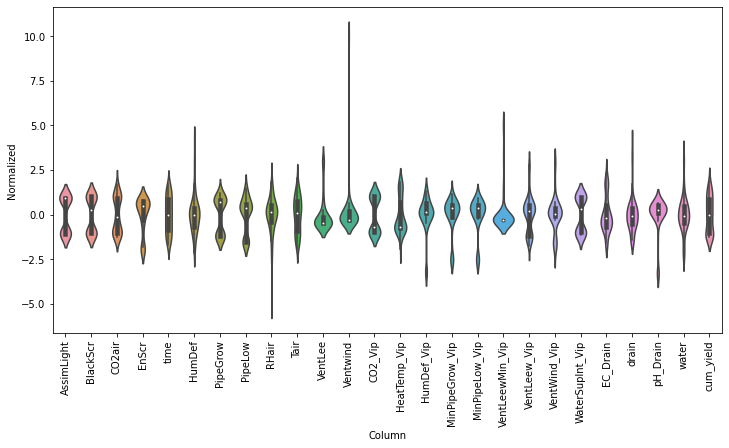

In [ ]:
df_std = (sonoma_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(sonoma_df.keys(), rotation=90)

# XGBoost

#SVM Regression

# Logistic Regression

# Time Series forecasting With TensorFlow

With the window Generator, I think what we need to do is establish that the "output" of that window is the total_prod_cum at the end of that window - the start of that window


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['time'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['time']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['time'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['time']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (2, 7, 26)
Inputs shape: (2, 6, 26)
labels shape: (2, 1, 1)
